In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

import random

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trainied lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=5, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    #print(X_test_lmse)
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    #print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val


def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    
    #dropping rows we will use for testing
    #data.drop(index=['1636-69-001','1636-69-114','1636-69-028'])
    data = data[data.subjectId!='1636-69-001']
    data = data[data.subjectId!='1636-69-114']
    data = data[data.subjectId!='11636-69-028']
    
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t")

    diabetic = data[data['subjectId'] == "1636-69-001"]
    prediabetic = data[data['subjectId'] == "1636-69-114"]
    non_diabetic = data[data['subjectId'] == "1636-69-028"]
    
    diabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    prediabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    non_diabetic.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    
    
    diabetic['Display Time'] = diabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    diabetic = diabetic.set_index(['Display Time'], drop=True)

    prediabetic['Display Time'] = prediabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    prediabetic = prediabetic.set_index(['Display Time'], drop=True)

    non_diabetic['Display Time'] = non_diabetic['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    non_diabetic = non_diabetic.set_index(['Display Time'], drop=True)

    return diabetic, prediabetic, non_diabetic
    
    

def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values

    plt.figure(figsize=(20, 8))
    plt.plot(test_val, label='True')
    plt.plot(lstm_pred, label='LSTM')
    plt.title("LSTM's Prediction")
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(ioa_val))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(rmse_val))
    
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))

In [3]:
train_set = trainingData()
print(train_set)
#remove rows from training data



                     GlucoseValue
Display Time                     
2015-11-24 00:37:20           123
2015-11-24 00:42:20           122
2015-11-24 00:47:20           119
2015-11-24 00:52:20           114
2015-11-24 00:57:20           111
...                           ...
2017-07-11 20:21:32            70
2017-07-11 20:26:32            64
2017-07-11 20:31:32            61
2017-07-11 20:36:32            62
2017-07-11 20:41:32            66

[101784 rows x 1 columns]


In [4]:
lstmModel = trainModel(train_set)

Train shape:  (101783, 1, 1)
Epoch 1/5
101783/101783 [==============================] - 202s 2ms/step - loss: 4.0752e-04
Epoch 2/5
101783/101783 [==============================] - 214s 2ms/step - loss: 3.5672e-04
Epoch 3/5
101783/101783 [==============================] - 203s 2ms/step - loss: 3.4845e-04
Epoch 4/5
101783/101783 [==============================] - 200s 2ms/step - loss: 3.4639e-04
Epoch 5/5
101783/101783 [==============================] - 209s 2ms/step - loss: 3.4411e-04


In [5]:
diabetic , prediabetic, non_diabetic = testingData()

In [6]:
predicted1, true1 = testModel(lstmModel,diabetic)
predicted2, true2 = testModel(lstmModel,prediabetic)
predicted3, true3 = testModel(lstmModel,non_diabetic)

1845/1845 [==============================] - 1s 799us/step
LSTM: 0.001231
1795/1795 [==============================] - 1s 822us/step
LSTM: 0.004655
1821/1821 [==============================] - 2s 1ms/step
LSTM: 0.002892


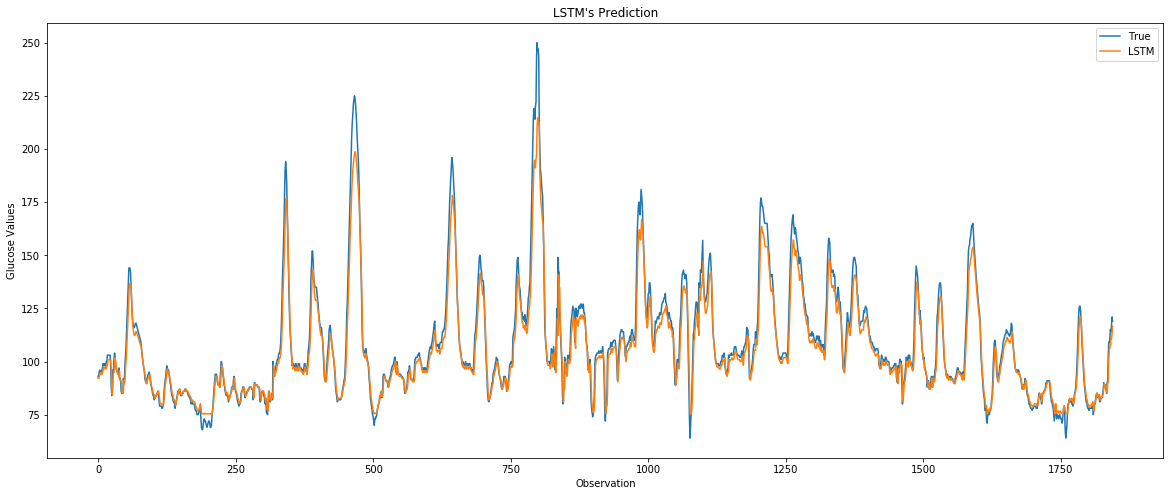

In [7]:
plot(predicted1, true1)

In [8]:
getMetrics(predicted1, true1)

Index of Agreement is: 0.9831429472183514
Mean Absolute Error is: 4.209564816854834
Root Mean Squared Error is: 6.525444786569261


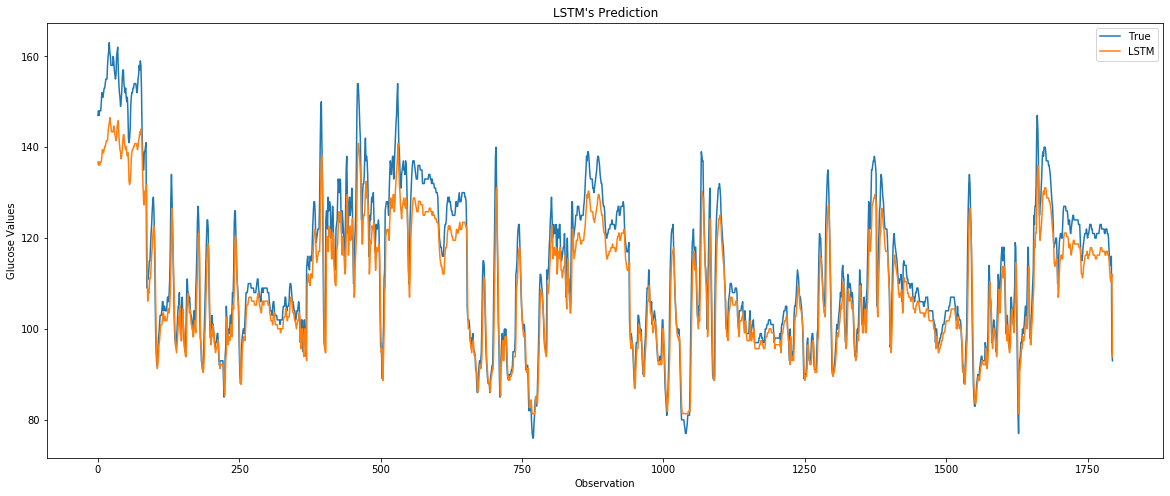

In [9]:
plot(predicted2, true2)

In [10]:
getMetrics(predicted2, true2)

Index of Agreement is: 0.9626441150637166
Mean Absolute Error is: 4.631960847052359
Root Mean Squared Error is: 5.93592890569177


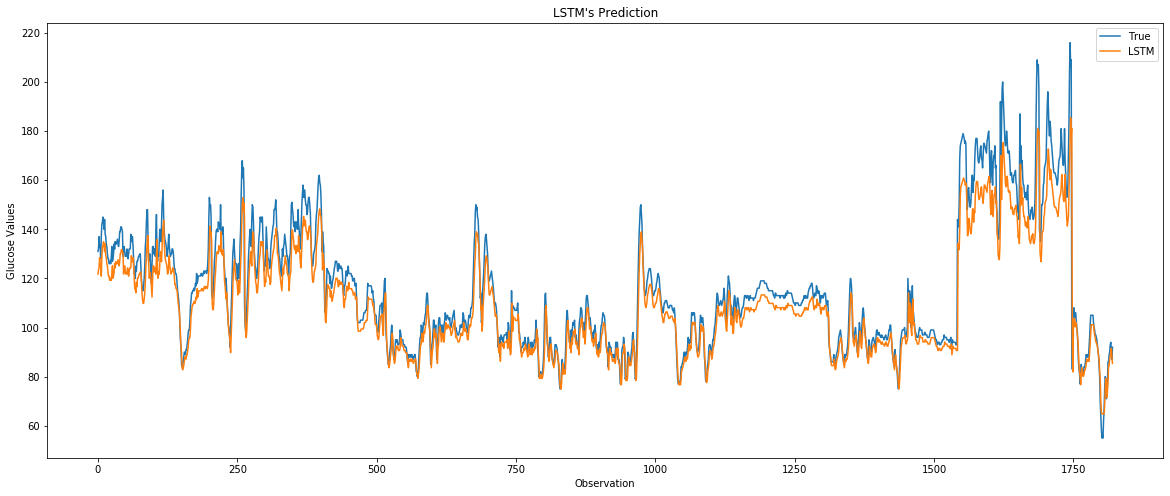

In [11]:
plot(predicted3, true3)

In [12]:
getMetrics(predicted3, true3)

Index of Agreement is: 0.9661502414051683
Mean Absolute Error is: 6.356963734257555
Root Mean Squared Error is: 8.65748086528665
